In [512]:
import time 
import pickle

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor

from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

np.random.seed(0)
torch.manual_seed(0)

In [513]:
path = 'ui_data_2.csv'  
data = pd.read_csv(path)
print(data.shape)

(5172, 10)


In [514]:
# # # Set max valid RSSI to 200
# data.iloc[:, [8, 9]] = data.iloc[:, [8, 9]].clip(upper=-110)

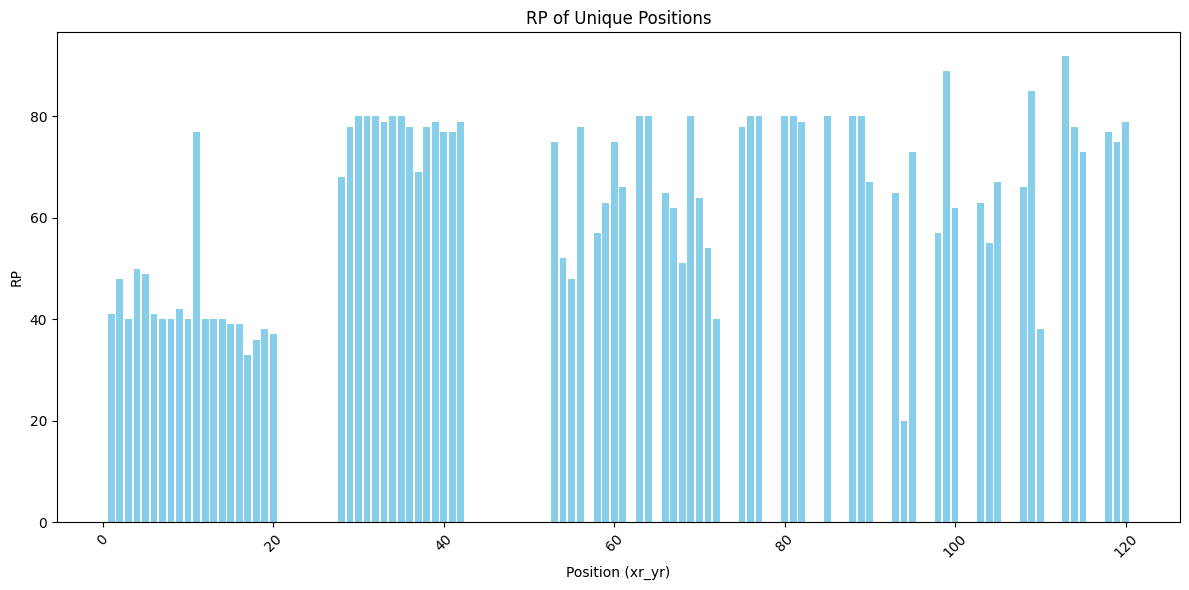

In [555]:
# Step 2: Count the frequency of each unique position
frequency = data['reference_point'].value_counts()

# If you want to reset the index and get a DataFrame
frequency_df = frequency.reset_index()
frequency_df.columns = ['reference_point', 'frequency']

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(frequency_df['reference_point'], frequency_df['frequency'], color='skyblue')
plt.xlabel('Position (xr_yr)')
plt.ylabel('RP')
plt.title('RP of Unique Positions')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [516]:
data.drop(columns=['position'], inplace=True)
data.sample(5)


,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen
3324,2025-03-01T02:34:09.0622749Z,RP67,12,DTE Student,72:a7:41:9c:77:cd,1,1826,2130,-70.0,NaN
15,2024-10-17T08:42:30.001785Z,RP1,8,DTE Student,72:a7:41:9c:77:cd,11,300,1368,-62.0,NaN
4950,2025-03-03T08:20:28.4149501Z,RP99,3,DTE Staff,70:a7:41:dc:77:cd,6,720,639,-59.0,NaN
3964,2025-03-01T04:12:48.8577823Z,RP74,5,DTE Staff,72:a7:41:9c:8e:55,11,1720,299,NaN,-82.0
2315,2025-02-25T04:18:03.1287201Z,RP119,4,DTE Student,72:a7:41:9c:77:cd,1,1520,639,-59.0,NaN


C:\Users\laure\AppData\Local\Temp\ipykernel_15180\3898255427.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='reference_point', y='rssi_ap_digilab', palette='Set3')
C:\Users\laure\AppData\Local\Temp\ipykernel_15180\3898255427.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='reference_point', y='rssi_ap_dosen', palette='Set3')


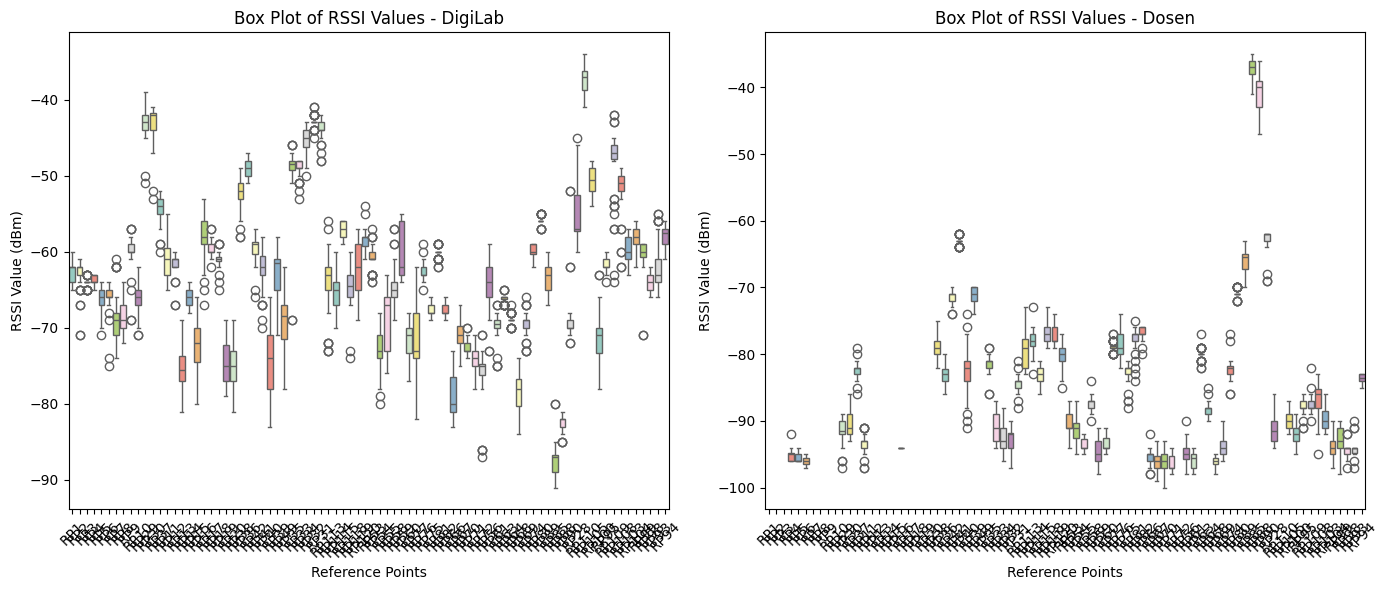

C:\Users\laure\AppData\Local\Temp\ipykernel_15180\3898255427.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x='reference_point', y='rssi_ap_digilab', palette='Set3')
C:\Users\laure\AppData\Local\Temp\ipykernel_15180\3898255427.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x='reference_point', y='rssi_ap_dosen', palette='Set3')


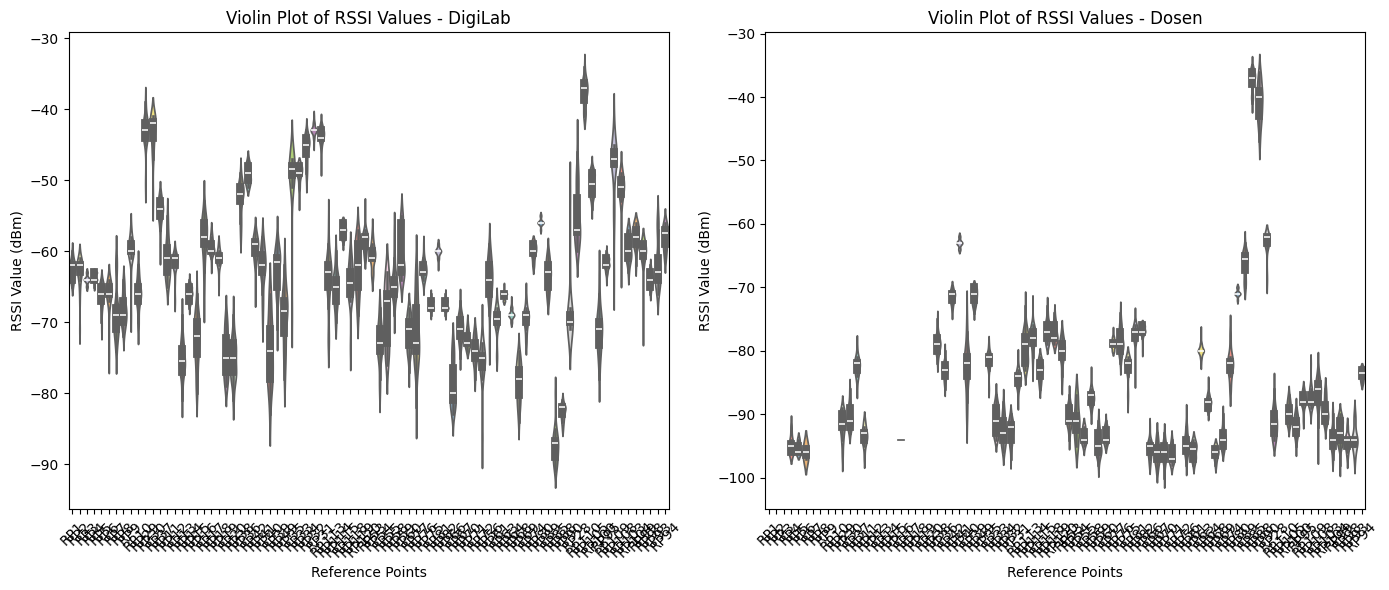

In [517]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(14, 6))  # Increased width for better label visibility

# Box plot for rssi_ap_digilab
plt.subplot(1, 2, 1)
sns.boxplot(data=data, x='reference_point', y='rssi_ap_digilab', palette='Set3')
plt.title('Box Plot of RSSI Values - DigiLab')
plt.ylabel('RSSI Value (dBm)')
plt.xlabel('Reference Points')
plt.xticks(rotation=45)  # Rotate x labels for better visibility

# Box plot for rssi_ap_dosen
plt.subplot(1, 2, 2)
sns.boxplot(data=data, x='reference_point', y='rssi_ap_dosen', palette='Set3')
plt.title('Box Plot of RSSI Values - Dosen')
plt.ylabel('RSSI Value (dBm)')
plt.xlabel('Reference Points')
plt.xticks(rotation=45)  # Rotate x labels for better visibility

plt.tight_layout()
plt.show()

# Now for the Violin plots
plt.figure(figsize=(14, 6))  # Increased width for better label visibility

# Violin plot for rssi_ap_digilab
plt.subplot(1, 2, 1)
sns.violinplot(data=data, x='reference_point', y='rssi_ap_digilab', palette='Set3')
plt.title('Violin Plot of RSSI Values - DigiLab')
plt.ylabel('RSSI Value (dBm)')
plt.xlabel('Reference Points')
plt.xticks(rotation=45)  # Rotate x labels for better visibility

# Violin plot for rssi_ap_dosen
plt.subplot(1, 2, 2)
sns.violinplot(data=data, x='reference_point', y='rssi_ap_dosen', palette='Set3')
plt.title('Violin Plot of RSSI Values - Dosen')
plt.ylabel('RSSI Value (dBm)')
plt.xlabel('Reference Points')
plt.xticks(rotation=45)  # Rotate x labels for better visibility

plt.tight_layout()
plt.show()


In [518]:
data['rssi_ap_dosen'].unique()

array([  nan,  -96.,  -94.,  -95.,  -92.,  -97.,  -90.,  -89.,  -91.,
        -93.,  -86.,  -88.,  -87.,  -81.,  -82.,  -83.,  -84.,  -85.,
        -79.,  -80.,  -78.,  -77.,  -75.,  -70.,  -71.,  -72.,  -73.,
        -74.,  -63.,  -64.,  -62.,  -76.,  -98.,  -99., -100.,  -69.,
        -66.,  -67.,  -65.,  -68.,  -37.,  -41.,  -40.,  -36.,  -38.,
        -35.,  -39.,  -43.,  -42.,  -44.,  -47.,  -45.])

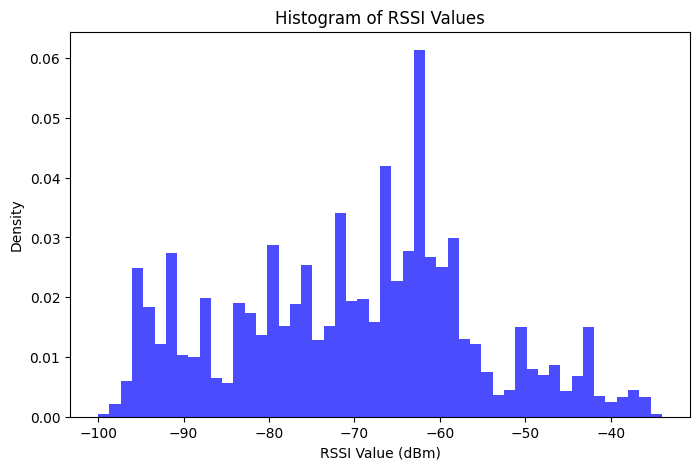

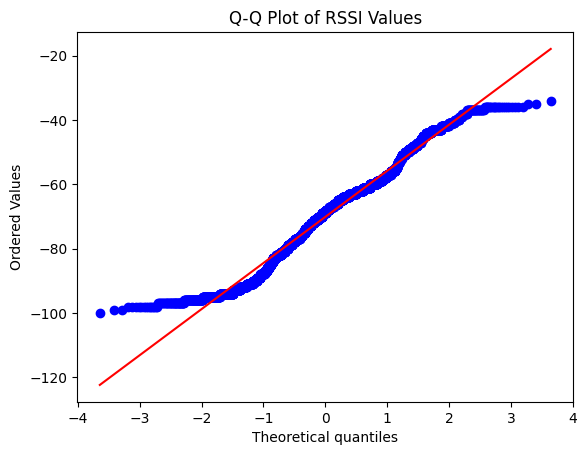

RSSI Skewness: 0.0227
RSSI Kurtosis: -0.5899


In [519]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import skew, kurtosis

# Select RSSI columns (replace with actual column names from your dataset)
rssi_digilab = data["rssi_ap_digilab"]
rssi_dosen = data["rssi_ap_dosen"]

rssi_digilab = rssi_digilab[rssi_digilab > -200]
rssi_dosen = rssi_dosen[rssi_dosen > -200]

# Combine both RSSI columns for analysis
rssi_values = np.concatenate([rssi_digilab, rssi_dosen])

# 1️⃣ Histogram (Check RSSI Distribution)
plt.figure(figsize=(8, 5))
plt.hist(rssi_values, bins=50, color='blue', alpha=0.7, density=True)
plt.xlabel("RSSI Value (dBm)")
plt.ylabel("Density")
plt.title("Histogram of RSSI Values")
plt.show()

# 2️⃣ Q-Q Plot (Check for Normality)
stats.probplot(rssi_values, dist="norm", plot=plt)
plt.title("Q-Q Plot of RSSI Values")
plt.show()

# 3️⃣ Skewness & Kurtosis (Numerical Analysis)
rssi_skewness = skew(rssi_values)
rssi_kurtosis = kurtosis(rssi_values)

print(f"RSSI Skewness: {rssi_skewness:.4f}")  # >0 means right-skewed, <0 means left-skewed
print(f"RSSI Kurtosis: {rssi_kurtosis:.4f}")  # >3 means heavy-tailed (outliers)


In [520]:
# Fill missing RSSI values
data['rssi_ap_digilab'] = data['rssi_ap_digilab'].fillna(-200)
data['rssi_ap_dosen'] = data['rssi_ap_dosen'].fillna(-200)

In [521]:
ap_coordinates = {
    'DTE Staff (Digilab)': (867, 1122),
    'DTE Staff (Dosen)': (2454, 520)
}

In [522]:
data = data[~data['reference_point'].isin(['RP49', 'RP74'])]

# Ensure the relative_position column exists with a default numeric value (-1 for unassigned)
data['relative_position'] = -1  # Using -1 to indicate unassigned values initially

# Define reference points that should be assigned a relative position of 0
zero_rps = (
    list(range(1, 21)) +   # RP1-20
    list(range(53, 57)) +  # RP53-56
    list(range(58, 62)) +  # RP58-61
    list(range(63, 65)) +  # RP63-64
    list(range(66, 73)) +  # RP66-72
    list(range(75, 78)) +  # RP75-77
    list(range(80, 89)) +  # RP80-88
    list(range(113, 116)) +  # RP113-115
    list(range(118, 121)) +  # RP118-120
    list(range(93, 96)) +
    list(range(98, 101)) +
    list(range(103, 106)) +
    list(range(108, 111)) 
)

# Define reference points that should be assigned a relative position of 1
one_rps = list(range(28, 43)) + [89, 90]  # RP28-42 and RP89-90


# Convert lists to sets for faster lookup
zero_rp_set = {f'RP{i}' for i in zero_rps}
one_rp_set = {f'RP{i}' for i in one_rps}

# Apply conditions to assign relative_position
data['relative_position'] = data['reference_point'].apply(
    lambda rp: 0 if rp in zero_rp_set else (1 if rp in one_rp_set else -1)
)

# Convert to integer type to ensure it's numeric
data['relative_position'] = data['relative_position'].astype(int)

# Check unique values to ensure no -1 remains
print("Unique values in relative_position:", data['relative_position'].unique())

# Check the first few rows to confirm the relative_position column was added correctly
print(data[['reference_point', 'relative_position']].head())

Unique values in relative_position: [0 1]
  reference_point  relative_position
0             RP1                  0
1             RP1                  0
2             RP1                  0
3             RP1                  0
4             RP1                  0


In [523]:
# Convert the 'time' column to datetime format
data['time'] = pd.to_datetime(data['time'])
# Convert to seconds since the epoch
data['time_numeric'] = data['time'].apply(lambda x: x.time())

In [524]:
# Define the mapping dictionary
bssid_mapping = {
    '70:a7:41:dc:8e:55': 1,
    '72:a7:41:9c:8e:55': 2,
    '70:a7:41:dc:77:cd': 3,
    '72:a7:41:9c:77:cd': 4
}

In [525]:
data['bssid'] = data['bssid'].map(bssid_mapping)
print(data[['bssid', 'bssid']].head())


   bssid  bssid
0      4      4
1      3      3
2      4      4
3      4      4
4      3      3


In [526]:
# Assuming 'reference_point' is your column name in the DataFrame
data['reference_point'] = data['reference_point'].str.replace('RP', '').astype(int)

# Check the result
print(data['reference_point'])

0        1
1        1
2        1
3        1
4        1
        ..
5167    94
5168    94
5169    94
5170    94
5171    94
Name: reference_point, Length: 5100, dtype: int32


In [527]:
data.sample(10)

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric
4429,2025-03-03 07:03:54.616875700+00:00,28,19,DTE Staff,3,6,759,1202,-57.0,-200.0,1,07:03:54.616875
5166,2025-03-03 08:57:01.323235500+00:00,94,4,DTE Staff,1,11,520,639,-200.0,-83.0,0,08:57:01.323235
3586,2025-03-01 03:17:41.440965900+00:00,56,20,DTE Staff,2,11,1479,1948,-200.0,-95.0,0,03:17:41.440965
2390,2025-02-25 04:28:09.318934300+00:00,120,3,DTE Staff,1,11,1520,838,-200.0,-80.0,0,04:28:09.318934
1261,2024-10-23 07:13:05.435539700+00:00,42,8,DTE Student,4,11,2454,1202,-60.0,-200.0,1,07:13:05.435539
2321,2025-02-25 04:18:35.251860500+00:00,119,5,DTE Staff,2,11,1520,639,-200.0,-77.0,0,04:18:35.251860
3900,2025-03-01 04:02:48.116093500+00:00,69,9,DTE Staff,1,11,2000,1567,-200.0,-94.0,0,04:02:48.116093
4766,2025-03-03 07:53:13.703058500+00:00,108,3,DTE Staff,2,11,1120,469,-200.0,-86.0,0,07:53:13.703058
3413,2025-03-01 02:47:41.352535500+00:00,70,20,DTE Staff,3,1,2000,1789,-71.0,-200.0,0,02:47:41.352535
1376,2024-10-23 07:30:00.553679800+00:00,41,17,DTE Staff,1,1,2454,1037,-200.0,-63.0,1,07:30:00.553679


In [528]:
# Save the final dataframe
data.to_csv('data_preprocessed.csv', index=False)
print(f"Data saved to {'data_preprocessed.csv'}")

Data saved to data_preprocessed.csv


In [529]:
def encode_and_save_labels(data, column_name, encoder_file_name='label_encoder.pkl'):
    # Initialize the LabelEncoder
    le = LabelEncoder()
    
    # Fit and transform the data
    encoded_values = le.fit_transform(data[column_name])
    
    # Replace the original column with encoded values
    data[column_name] = encoded_values
    
    # Save the encoder to a file
    with open(encoder_file_name, 'wb') as file:
        pickle.dump(le, file)
    
    print(f"Encoded {column_name} and saved encoder to {encoder_file_name}")
    
    return data

def decode_labels(data, column_name, encoder_file_name='label_encoder.pkl'):
    # Load the encoder from the file
    with open(encoder_file_name, 'rb') as file:
        le = pickle.load(file)
    
    # Transform the encoded values back to original labels
    decoded_values = le.inverse_transform(data[column_name])
    
    # Replace the encoded column with decoded values
    data[column_name] = decoded_values
    
    print(f"Decoded {column_name} using encoder from {encoder_file_name}")
    
    return data

def decode_predictions(y_pred, encoder_file_name='label_encoder.pkl'):
    # Load the encoder from the file
    with open(encoder_file_name, 'rb') as file:
        le = pickle.load(file)
    
    # Transform the encoded predictions back to original labels
    decoded_predictions = le.inverse_transform(y_pred)
    
    print(f"Decoded predictions using encoder from {encoder_file_name}")
    
    return decoded_predictions

## Scaling using Robust Scaler


In [530]:
print("Columns in DataFrame:", data.columns)
print("Shape of DataFrame:", data.shape)

Columns in DataFrame: Index(['time', 'reference_point', 'iteration', 'ssid', 'bssid', 'channel',
       'xr', 'yr', 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position',
       'time_numeric'],
      dtype='object')
Shape of DataFrame: (5100, 12)


In [531]:
df = data.iloc[:, [1, 2, 4, 5, 8 , 9, 10]]
print("\nColumns in X:", df.columns.tolist())

df = encode_and_save_labels(df, 'reference_point')
df = df.rename(columns={'reference_point': 'label'})


Columns in X: ['reference_point', 'iteration', 'bssid', 'channel', 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position']
Encoded reference_point and saved encoder to label_encoder.pkl


C:\Users\laure\AppData\Local\Temp\ipykernel_15180\2956030956.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column_name] = encoded_values


In [532]:
df

,label,iteration,bssid,channel,rssi_ap_digilab,rssi_ap_dosen,relative_position
0,0,3,4,11,-64.0,-200.0,0
1,0,1,3,11,-63.0,-200.0,0
2,0,1,4,11,-63.0,-200.0,0
3,0,2,4,11,-64.0,-200.0,0
4,0,2,3,11,-65.0,-200.0,0
...,...,...,...,...,...,...,...
5167,63,4,2,11,-200.0,-83.0,0
5168,63,5,4,6,-57.0,-200.0,0
5169,63,5,3,6,-58.0,-200.0,0
5170,63,5,1,11,-200.0,-84.0,0


### Are there overlapping points?

In [533]:
binned_data = df.copy()
binned_data.iloc[:, :-1] = np.round(binned_data.iloc[:, :-1]) 
overlapping_points = binned_data.groupby(list(binned_data.columns[:-1]))['label'].nunique()
overlapping_points = overlapping_points[overlapping_points > 1]
overlapping_data = binned_data.set_index(list(binned_data.columns[:-1])).loc[overlapping_points.index]

overlapping_data

,,,,,,relative_position
label,iteration,bssid,channel,rssi_ap_digilab,rssi_ap_dosen,


In [534]:
# delete overlapping data 
non_overlapping_mask = ~binned_data.set_index(list(binned_data.columns[:-1])).index.isin(overlapping_points.index)
df = df[non_overlapping_mask]
df.shape

(5100, 7)

## Regression Model

In [535]:
X = data.iloc[:, [1, 4, 5, 8 , 9, 10]]
y = data.iloc[:, [6, 7]] # Selecting reference_point (ap_name), xr (x), yr (y)

In [536]:
print("\nColumns in X:", X.columns.tolist())
print("Columns in y:", y.columns.tolist())


Columns in X: ['reference_point', 'bssid', 'channel', 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position']
Columns in y: ['xr', 'yr']


In [537]:
print(X.head())
print(X.dtypes)

   reference_point  bssid  channel  rssi_ap_digilab  rssi_ap_dosen  \
0                1      4       11            -64.0         -200.0   
1                1      3       11            -63.0         -200.0   
2                1      4       11            -63.0         -200.0   
3                1      4       11            -64.0         -200.0   
4                1      3       11            -65.0         -200.0   

   relative_position  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
reference_point        int32
bssid                  int64
channel                int64
rssi_ap_digilab      float64
rssi_ap_dosen        float64
relative_position      int32
dtype: object


In [538]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        if isinstance(features, np.ndarray): self.features = torch.tensor(features, dtype=torch.float32)
        else: self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    

regression_data_scaled = RobustScaler().fit_transform(X)

dataset = CustomDataset(regression_data_scaled, y)

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

dataset = CustomDataset(regression_data_scaled, y)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [539]:
print("\nColumns in X:", X.columns.tolist())
print("Columns in y:", y.columns.tolist())


Columns in X: ['reference_point', 'bssid', 'channel', 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position']
Columns in y: ['xr', 'yr']


In [540]:
# Import necessary libraries
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Assuming X and y are preprocessed and split-ready
# Ensure y is a numpy array
y = np.array(y)  # Convert to numpy array if y is a pandas DataFrame or Series

# Step 1: Split the dataset into 70% training, 30% remaining (not final test set)
X_train, X_unused, y_train, y_unused = train_test_split(regression_data_scaled, y, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=1)

# Step 2: Use 100% of the dataset as the test set
X_test = regression_data_scaled  # Full dataset as test set
y_test = y  # Full dataset labels

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]} (Full Dataset)")

Training set size: 3141
Test set size: 5100 (Full Dataset)


In [541]:
print(f"Training samples: {X_train.shape[0]}, Features: {X_train.shape[1]}")


Training samples: 3141, Features: 6


In [542]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    max_depth=6,  # Increase depth for more complex patterns
    learning_rate=0.05,  # Reduce step size for better accuracy
    n_estimators=500  # More trees for better generalization
)

# Use MultiOutputRegressor to handle multiple targets
multi_xgb = MultiOutputRegressor(xgb_model)

In [543]:
# Define hyperparameters for tuning
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [3, 4, 5],
    'estimator__learning_rate': [0.01, 0.1, 0.3]
}

In [544]:
def remove_outliers_before_training(X, y, threshold=1000):
    """Remove samples where MSE is an outlier before training the model."""
    # Predict rough initial values using a simple model to estimate errors
    temp_model = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42))
    temp_model.fit(X, y)
    y_pred = temp_model.predict(X)
    
    # Compute errors
    mse = np.mean((y - y_pred)**2, axis=1)
    
    # Keep only samples with MSE below the threshold
    mask = mse < threshold
    return X[mask], y[mask]

In [545]:
X_train, y_train = remove_outliers_before_training(X_train, y_train, threshold=1000)


In [546]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(multi_xgb, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   device=None,
                                                                   early_stopping_rounds=None,
                                                                   enable_categorical=False,
                                                                   eval_metric=None,
                                                                   feature_types=None,
                                                                   gamma=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constr...
                                                                   max_depth=6,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=500,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   random_state=42, ...)),
             n_jobs=-1,
             param_grid={'estimator__learning_rate': [0.01, 0.1, 0.3],
                         'estimator__max_depth': [3, 4, 5],
                         'estimator__n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [547]:
# Print the best parameters
print("Best parameters found by grid search:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

# Get the best model
best_model = grid_search.best_estimator_

# Print all hyperparameters of the best model
print("\nAll hyperparameters of the best model:")
for i, estimator in enumerate(best_model.estimators_):
    print(f"\nEstimator for dimension {i+1} ({'x' if i==0 else 'y' if i==1 else 'z'}):")
    for param, value in estimator.get_params().items():
        print(f"  {param}: {value}")

Best parameters found by grid search:
estimator__learning_rate: 0.3
estimator__max_depth: 4
estimator__n_estimators: 300

All hyperparameters of the best model:

Estimator for dimension 1 (x):
  objective: reg:squarederror
  base_score: None
  booster: None
  callbacks: None
  colsample_bylevel: None
  colsample_bynode: None
  colsample_bytree: None
  device: None
  early_stopping_rounds: None
  enable_categorical: False
  eval_metric: None
  feature_types: None
  gamma: None
  grow_policy: None
  importance_type: None
  interaction_constraints: None
  learning_rate: 0.3
  max_bin: None
  max_cat_threshold: None
  max_cat_to_onehot: None
  max_delta_step: None
  max_depth: 4
  max_leaves: None
  min_child_weight: None
  missing: nan
  monotone_constraints: None
  multi_strategy: None
  n_estimators: 300
  n_jobs: None
  num_parallel_tree: None
  random_state: 42
  reg_alpha: None
  reg_lambda: None
  sampling_method: None
  scale_pos_weight: None
  subsample: None
  tree_method: None
 

In [548]:
# Make predictions
y_pred = best_model.predict(X_test)

# # Predict on training set
# y_pred_train = best_model.predict(X_train)
# train_mse = mean_squared_error(y_train, y_pred_train)

# # Predict on test set
# y_pred_test = best_model.predict(X_test)
# test_mse = mean_squared_error(y_test, y_pred_test)

# # Print results
# print(f"Training MSE: {train_mse:.4f}")
# print(f"Testing MSE: {test_mse:.4f}")

In [549]:
import pandas as pd

# Function to compute MSE statistics before and after outlier removal
def compute_mse_statistics(y_true, y_pred, percentile=90):
    """Compute statistics of MSE before and after removing outliers."""
    mse_per_sample = np.mean((y_true - y_pred) ** 2, axis=1)

    # Compute before filtering statistics
    stats_before = {
        "Mean MSE": np.mean(mse_per_sample),
        "Median MSE": np.median(mse_per_sample),
        "Max MSE": np.max(mse_per_sample),
        "Min MSE": np.min(mse_per_sample),
        "Std Dev MSE": np.std(mse_per_sample),
    }

    # Compute percentile threshold for filtering
    threshold = np.percentile(mse_per_sample, percentile)
    mask = mse_per_sample < threshold
    filtered_mse = mse_per_sample[mask]

    # Compute after filtering statistics
    stats_after = {
        "Mean MSE": np.mean(filtered_mse),
        "Median MSE": np.median(filtered_mse),
        "Max MSE": np.max(filtered_mse),
        "Min MSE": np.min(filtered_mse),
        "Std Dev MSE": np.std(filtered_mse),
    }

    # Convert to DataFrame for easy visualization
    mse_comparison = pd.DataFrame([stats_before, stats_after], index=["Before Outlier Removal", "After Outlier Removal"])
    
    return mse_comparison

# Ensure correct test set subset matches prediction size
filtered_mse_stats = compute_mse_statistics(y_test[:len(y_pred)], y_pred, percentile=95)

filtered_mse_stats.head()


,Mean MSE,Median MSE,Max MSE,Min MSE,Std Dev MSE
Before Outlier Removal,33.998238,0.263508,28107.884013,0.000016,647.565384
After Outlier Removal,1.375730,0.221329,20.540985,0.000016,2.961025


In [550]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"\nOverall Mean Squared Error: {mse}")

# Calculate and print MSE for each coordinate
for i, coord in enumerate(['x', 'y']):
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    print(f"MSE for {coord}: {mse}")


Overall Mean Squared Error: 33.99824142456055
MSE for x: 3.3465545177459717
MSE for y: 64.6499252319336


Number of predictions: 5100


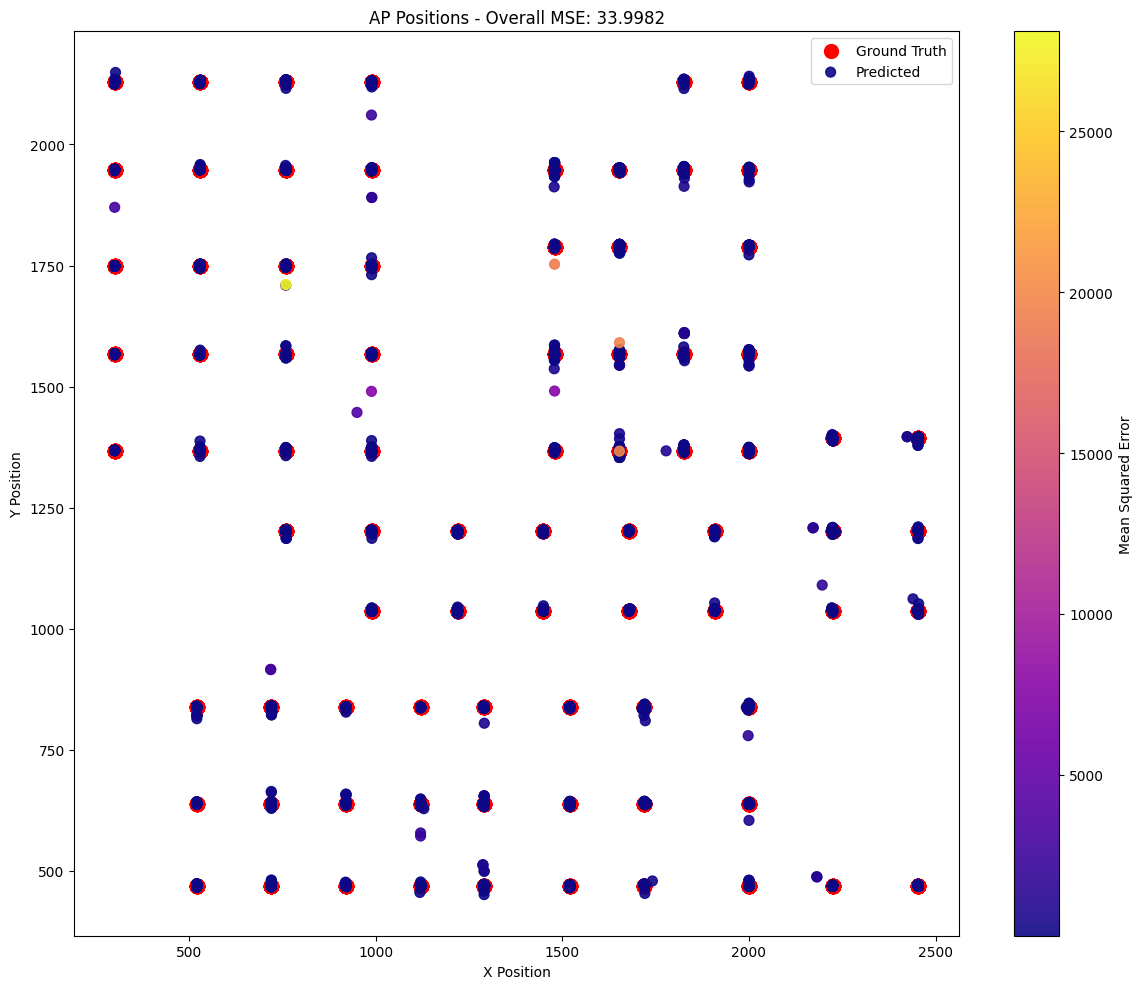

In [551]:
def plot_2d_ap_positions(y_true, y_pred):
    # Calculate MSE for each point
    mse = np.mean((y_true - y_pred)**2, axis=1)
    
    print(f"Number of predictions: {len(y_pred)}")
    
    # Create the 2D plot
    plt.figure(figsize=(12, 10))
    
    # Plot ground truth positions in blue
    plt.scatter(y_true[:, 0], y_true[:, 1], 
                c='red', marker='o', s=100, alpha=1, label='Ground Truth')
    
    # Adjust normalization range based on the MSE values
    norm = Normalize(vmin=mse.min(), vmax=mse.max())
    
    # Plot predicted positions with color based on MSE
    scatter = plt.scatter(y_pred[:, 0], y_pred[:, 1],
                          c=mse, norm=norm, cmap='plasma', s=50, alpha=0.9, label='Predicted')
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Mean Squared Error')
    
    # Calculate overall MSE
    overall_mse = mean_squared_error(y_true, y_pred)
    
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.title(f'AP Positions - Overall MSE: {overall_mse:.4f}')
    
    plt.tight_layout()
    plt.show()

# Plot the positions
plot_2d_ap_positions(y_test, y_pred)

In [552]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Number of predictions: 5100


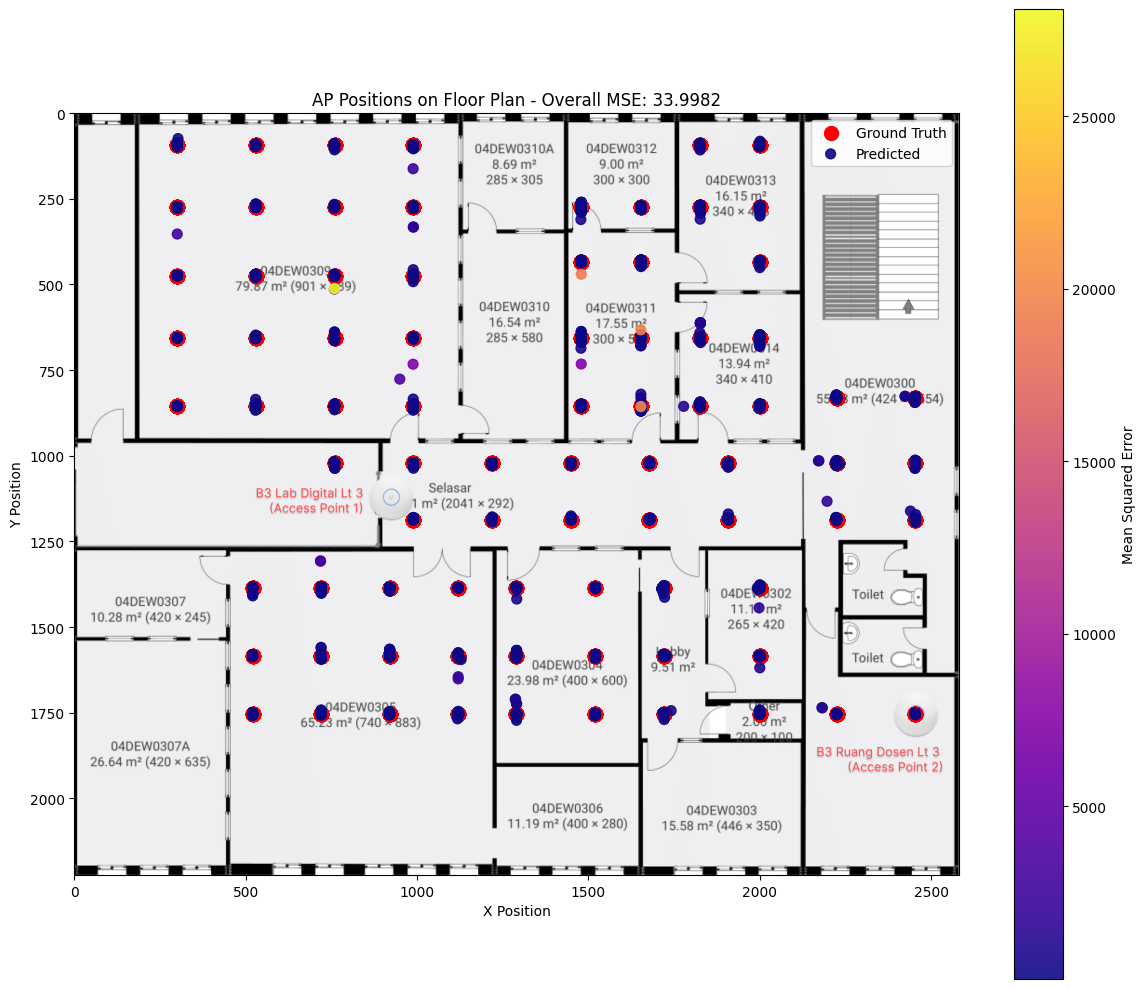

In [553]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from matplotlib.colors import Normalize
from sklearn.metrics import mean_squared_error

def plot_2d_ap_positions_with_floorplan(y_true, y_pred, floorplan_path, real_to_pixel_scale=None):
    # Load the floor plan image
    floorplan = cv2.imread(floorplan_path)
    floorplan = cv2.cvtColor(floorplan, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Get image dimensions
    img_height, img_width, _ = floorplan.shape

    # If a scaling factor is provided, transform real-world coordinates to pixel space
    if real_to_pixel_scale:
        y_true = y_true * real_to_pixel_scale
        y_pred = y_pred * real_to_pixel_scale

    # Flip only the Y-coordinates of the predictions
    y_pred[:, 1] = img_height - y_pred[:, 1]
    y_true[:, 1] = img_height - y_true[:, 1]  # Optional: If ground truth also needs flipping

    # Calculate MSE for each point
    mse = np.mean((y_true - y_pred) ** 2, axis=1)

    print(f"Number of predictions: {len(y_pred)}")

    # Create the 2D plot with the floor plan as the background
    plt.figure(figsize=(12, 10))
    plt.imshow(floorplan, extent=[0, img_width, img_height, 0])  # Floor plan remains in place

    # Plot ground truth positions in red
    plt.scatter(y_true[:, 0], y_true[:, 1], 
                c='red', marker='o', s=100, alpha=1, label='Ground Truth')

    # Adjust normalization range based on the MSE values
    norm = Normalize(vmin=mse.min(), vmax=mse.max())

    # Plot predicted positions with color based on MSE
    scatter = plt.scatter(y_pred[:, 0], y_pred[:, 1],
                          c=mse, norm=norm, cmap='plasma', s=50, alpha=0.9, label='Predicted')

    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Mean Squared Error')

    # Calculate overall MSE
    overall_mse = mean_squared_error(y_true, y_pred)

    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.title(f'AP Positions on Floor Plan - Overall MSE: {overall_mse:.4f}')

    plt.tight_layout()
    plt.show()

# Example usage
floorplan_path = "floorplan.png"  # Update this to your floorplan image path
plot_2d_ap_positions_with_floorplan(y_test, y_pred, floorplan_path)


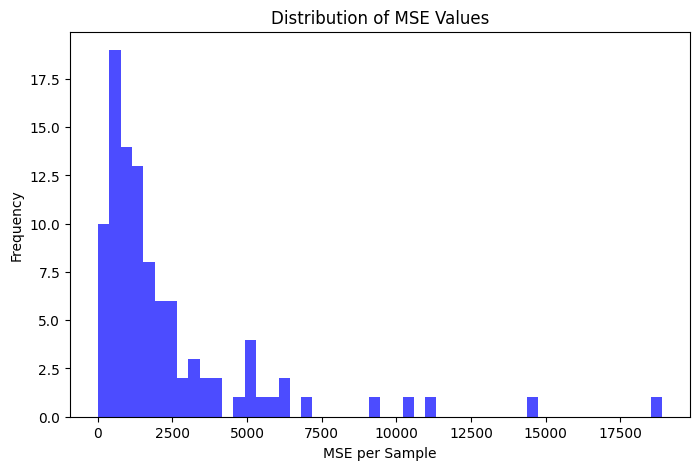

In [554]:
# Re-import necessary libraries after execution state reset
import numpy as np
import matplotlib.pyplot as plt

# Simulated test set (since actual y_test and y_pred are missing due to reset)
np.random.seed(42)
y_test = np.random.rand(100, 2) * 1000  # Simulating ground truth (100 samples, 2D coordinates)
y_pred = y_test + np.random.normal(0, 50, size=y_test.shape)  # Simulating predicted values with some noise

# Compute MSE per sample
mse_per_sample = np.mean((y_test - y_pred) ** 2, axis=1)

# Plot the histogram of MSE values
plt.figure(figsize=(8, 5))
plt.hist(mse_per_sample, bins=50, color='blue', alpha=0.7)
plt.xlabel("MSE per Sample")
plt.ylabel("Frequency")
plt.title("Distribution of MSE Values")
plt.show()
